# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [2]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits
from astropy.visualization import simple_norm

In [3]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/UGC04416/aUGC04416_B.fits')
data = hdu['PRIMARY'].data

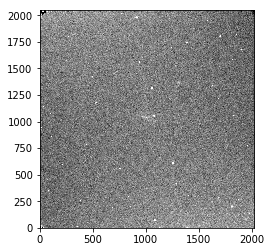

In [4]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=16, vmax=19)

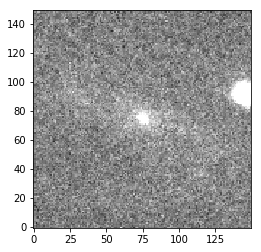

In [5]:
#cut
from astropy.nddata import Cutout2D
position = (1002, 1037)
size=(150,150)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=16, vmax=19)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [6]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

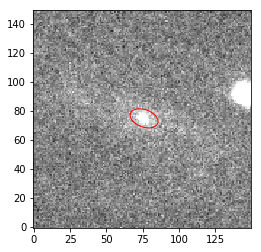

In [7]:
# how does it look?
geometry = EllipseGeometry (x0=76, y0=75, sma=10, eps=0.6,pa=160*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=16, vmax=19)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [8]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [9]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,3.406184243073326,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5209868481924366,3.2521776761093757,0.012952873609684532,0.28820730135199313,0.028973296963315114,170.815524224,3.59297876617,0.6226173284840184,13,0,10,0
0.5730855330116803,3.228819639700532,0.013800898041919873,0.29464373193494675,0.028749193006432035,170.449964031,3.4996011597,0.6318499636937771,13,0,10,0
0.6303940863128483,3.205169277925568,0.01446715898626443,0.3032333792486589,0.028771249660517847,170.530467743,3.42131476645,0.6523798343802719,13,0,10,0
0.6934334949441332,3.1912285002882137,0.014665091944335695,0.35452802940505135,0.028143367703615106,170.695305261,2.95160743601,0.7286709155368621,13,0,10,0
0.7627768444385465,3.180838337774948,0.014812041964655407,0.4096782597670829,0.025649398086809706,171.500200775,2.40872200196,0.7517938216831891,13,0,10,0
0.8390545288824012,3.171593296571408,0.015266135977878249,0.46122889761031155,0.0231373284381163,172.591149218,1.99446559065,0.7507076684280843,13,0,10,0
0.9229599817706413,3.1612146168316673,0.0171479072471608,0.5076956859568607,0.0229863139255422,173.459392217,1.85618110664,0.8113917015045018,13,0,10,0


Text(0,0.5,'Ellipticity')

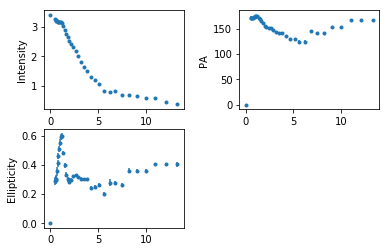

In [14]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [11]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5,1,'Residual')

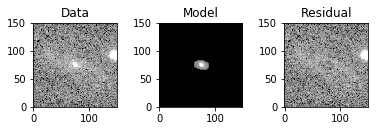

In [12]:
norm_model = simple_norm(model_image,stretch='asinh',percent=99.9)
norm_data = simple_norm(cutout.data,stretch='asinh',percent=98.5)
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', norm=norm_data)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', norm=norm_model)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', norm=norm_data)
ax3.set_title('Residual')